# Content-based Movie Rating Estimation

Import required packages.

In [1]:
import math
import numpy as np
from numpy import linalg as LA
import pandas as pd
from IPython.display import Image, display

In [2]:
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

### Movies Weight Matrix on Genres

Read movie metadata from a csv file.

In [3]:
movies = pd.read_csv('movies_w_imgurl.csv')

Split genres and stack genres into one column.

In [4]:
movieGenres = pd.DataFrame(data=movies['genres'].str.split('|').apply(pd.Series, 1).stack(), columns=['genre'])
movieGenres.index = movieGenres.index.droplevel(1)

Count movies that have each genre and then compute IDF of genres.

In [5]:
genres = pd.DataFrame(data = movieGenres.groupby('genre')['genre'].count())
genres.columns = ['movieCount']
totalItems = movies.shape[0]
genres['idf'] = genres['movieCount'].apply(lambda x: math.log10(totalItems/x))

Join genre's IDF to movie genre DataFrame.

In [6]:
movieGenreWeights = movieGenres.join(genres['idf'], on='genre')

In [7]:
movieWeights = movies[['movieId']]
for genre in genres.index:
    movieWeights = movieWeights.join(movieGenreWeights[movieGenreWeights['genre'] == genre][['idf']].rename(columns={'idf':genre}))
movieWeights.fillna(0, inplace=True)

In [8]:
movieWeights

,movieId,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.0,0.00,0.91,1.31,1.19,0.44,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
1,2,0.0,0.00,0.91,0.00,1.19,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
2,3,0.0,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.77,0.00,0.00,0.0,0.0
3,4,0.0,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.32,...,0.0,0.00,0.0,0.0,0.00,0.77,0.00,0.00,0.0,0.0
4,5,0.0,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
5,6,0.0,0.77,0.00,0.00,0.00,0.00,0.92,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.72,0.0,0.0
6,7,0.0,0.00,0.00,0.00,0.00,0.44,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.77,0.00,0.00,0.0,0.0
7,8,0.0,0.00,0.91,0.00,1.19,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
8,9,0.0,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0
9,10,0.0,0.77,0.91,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.72,0.0,0.0


### Movie-Movie Cosine Similarity Matrix

Compute $l_2$-norm of movies.

In [9]:
movieNorms = pd.DataFrame(data=LA.norm(movieWeights.iloc[:,1:].values, ord=2, axis=1), index=movieWeights.index, columns=['norm2'])

Normalize movie vector so that similarity can be computed simply by inner product between vectors.

$$ cosine(u, v)=\frac{\sum_{\forall i}{u_i v_i}}{||u||_2||v||_2}=\sum_{\forall i}{\frac{u_i v_i}{||u||_2||v||_2}}=\sum_{\forall i}{\frac{u_i}{||u||_2}\frac{v_i}{||v||_2}}=u'\cdot v'$$

In [10]:
normalizedMovieWeights = pd.DataFrame(index=movieWeights.index)
norms = movieNorms['norm2']
for genre in genres.index:
    normalizedMovieWeights[genre] = movieWeights[genre].divide(norms)

Create item-item similarity matrix

In [11]:
sims = pd.DataFrame(data=np.matmul(normalizedMovieWeights, normalizedMovieWeights.T), index=movieWeights['movieId'])
sims.columns = index=movieWeights['movieId']

In [12]:
sims

movieId,1,2,3,4,5,6,7,8,9,10,...,161830,161918,161944,162376,162542,162672,163056,163949,164977,164979
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.00,0.81,0.09,0.09,0.19,0.00,0.09,0.64,0.00,0.25,...,0.00,0.19,0.00,0.00,0.00,0.29,0.47,0.0,0.19,0.0
2,0.81,1.00,0.00,0.00,0.00,0.00,0.00,0.80,0.00,0.32,...,0.00,0.23,0.00,0.00,0.00,0.36,0.58,0.0,0.00,0.0
3,0.09,0.00,1.00,0.94,0.50,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.63,0.54,0.00,0.0,0.50,0.0
4,0.09,0.00,0.94,1.00,0.47,0.00,0.94,0.00,0.00,0.00,...,0.08,0.00,0.34,0.34,0.60,0.60,0.00,0.0,0.47,0.0
5,0.19,0.00,0.50,0.47,1.00,0.00,0.50,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.00,0.0
6,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.55,0.57,...,0.29,0.22,0.00,0.00,0.35,0.00,0.22,0.0,0.00,0.0
7,0.09,0.00,1.00,0.94,0.50,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.63,0.54,0.00,0.0,0.50,0.0
8,0.64,0.80,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.40,...,0.00,0.29,0.00,0.00,0.00,0.45,0.28,0.0,0.00,0.0
9,0.00,0.00,0.00,0.00,0.00,0.55,0.00,0.00,1.00,0.55,...,0.00,0.41,0.00,0.00,0.00,0.00,0.39,0.0,0.00,0.0


## Recommend Movies based on Predicted Ratings

For visual analysis, define a function for displaying movie with image.

In [13]:
def displayMovies(movieIds, ratings=[]):
    i = 0
    for movieId in movieIds:
        mov = movies[movies['movieId'] == movieId].iloc[0]
        display(Image(mov.imgurl))
        print(mov.title)
        print(mov.genres)
        if i < len(ratings):
            print(ratings[i])
        i += 1

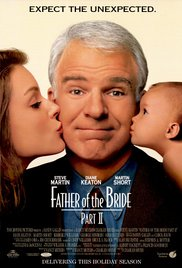

Father of the Bride Part II (1995)
Comedy


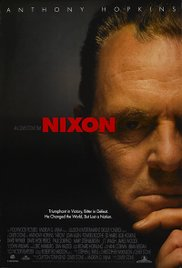

Nixon (1995)
Drama


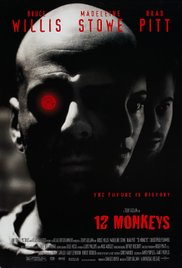

Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
Mystery|Sci-Fi|Thriller


In [14]:
displayMovies([5, 14, 32])

Read ratings as train and test datasets.

In [15]:
ratings = pd.read_csv('ratings-9_1.csv')
train = ratings[ratings['type'] == 'train'][['userId', 'movieId', 'rating']]
test = ratings[ratings['type'] == 'test'][['userId', 'movieId', 'rating']]

Recommend items for test users.

In [16]:
users = [33, 39, 77, 144, 238]

In [23]:
userId = 33
userRatings = train[train['userId'] == userId][['movieId', 'rating']]

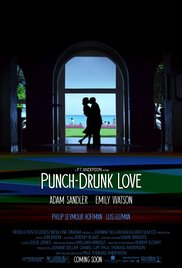

Punch-Drunk Love (2002)
Comedy|Drama|Romance
5.0


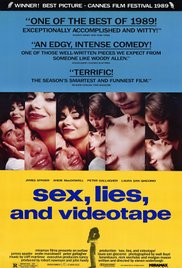

Sex, Lies, and Videotape (1989)
Drama
5.0


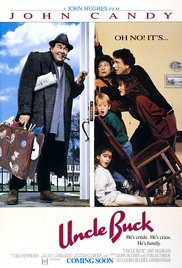

Uncle Buck (1989)
Comedy
5.0


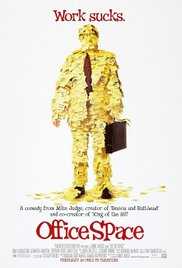

Office Space (1999)
Comedy|Crime
5.0


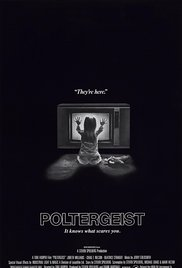

Poltergeist (1982)
Horror|Thriller
5.0


In [24]:
topRatings = userRatings.sort_values(by='rating', ascending=False).head(5)
displayMovies(topRatings['movieId'].values, topRatings['rating'].values)

In [25]:
recSimSums = LA.norm(sims.loc[userRatings['movieId'].values, :].T.values, ord=1, axis=1)
recWeightedRatingSums = np.matmul(sims.loc[userRatings['movieId'].values, :].T.values, userRatings['rating'].values)
recItemRatings = pd.DataFrame(data=np.divide(recWeightedRatingSums, recSimSums), index=sims.index)
recItemRatings.columns = ['prediction']

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


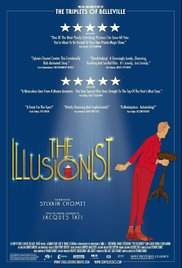

Illusionist, The (L'illusionniste) (2010)
Animation


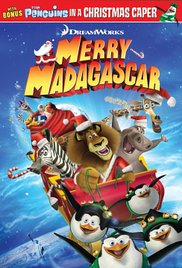

Merry Madagascar (2009)
Animation


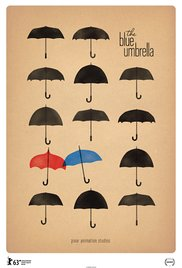

Blue Umbrella, The (2013)
Animation


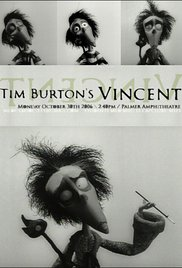

Vincent (1982)
Animation


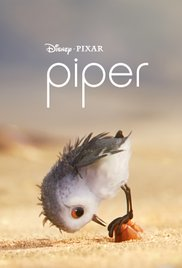

Piper (2016)
Animation


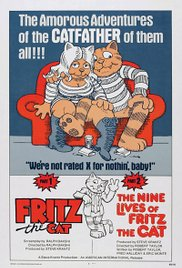

Fritz the Cat (1972)
Animation


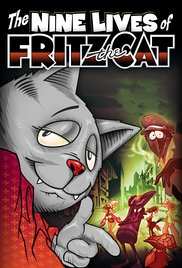

Nine Lives of Fritz the Cat, The (1974)
Animation


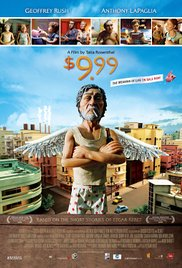

$9.99 (2008)
Animation


/usr/local/lib/python3.6/site-packages/IPython/core/formatters.py:362: FormatterWarning: image/png formatter returned invalid type <class 'float'> (expected (<class 'bytes'>, <class 'str'>)) for object: <IPython.core.display.Image object>
  FormatterWarning


<IPython.core.display.Image object>

Fern flowers (Fleur de fougère) (1949)
Animation


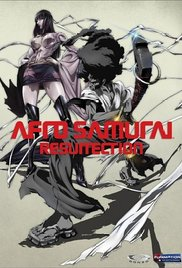

Afro Samurai: Resurrection (2009)
Animation


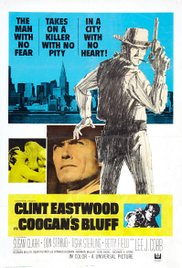

Coogan's Bluff (1968)
Crime


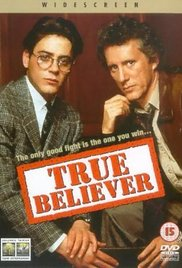

True Believer (1989)
Crime


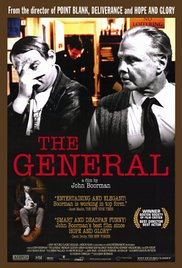

General, The (1998)
Crime


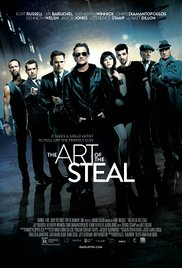

Art of the Steal, The (2013)
Crime


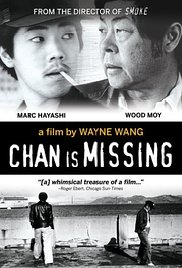

Chan Is Missing (1982)
Crime


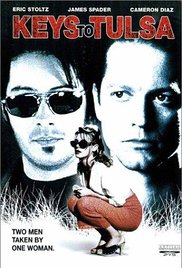

Keys to Tulsa (1997)
Crime


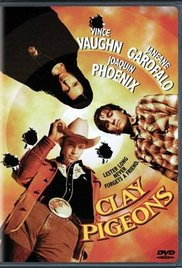

Clay Pigeons (1998)
Crime


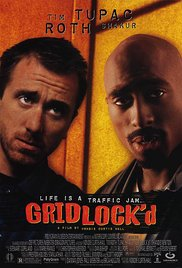

Gridlock'd (1997)
Crime


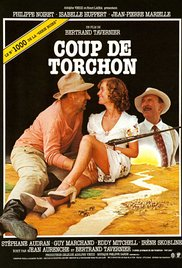

Coup de torchon (Clean Slate) (1981)
Crime


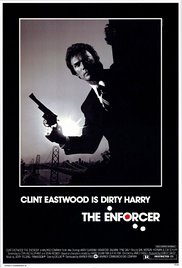

Enforcer, The (1976)
Crime


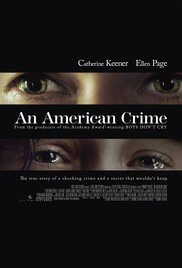

American Crime, An (2007)
Crime


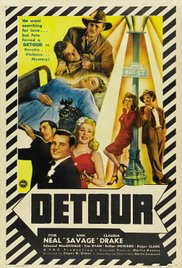

Detour (1945)
Crime|Film-Noir


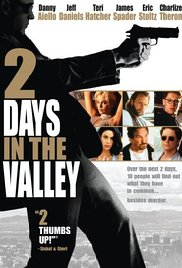

2 Days in the Valley (1996)
Crime|Film-Noir


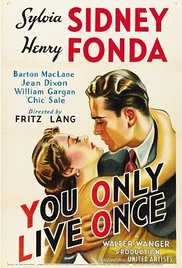

You Only Live Once (1937)
Crime|Film-Noir


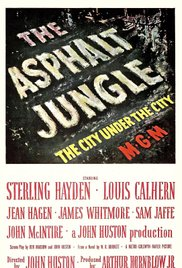

Asphalt Jungle, The (1950)
Crime|Film-Noir


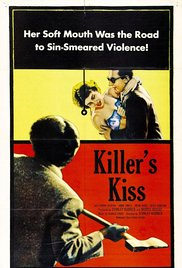

Killer's Kiss (1955)
Crime|Film-Noir


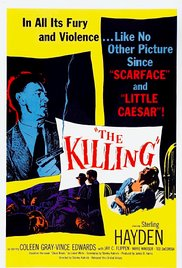

Killing, The (1956)
Crime|Film-Noir


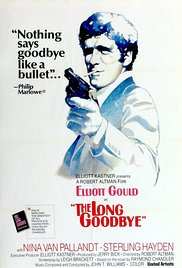

Long Goodbye, The (1973)
Crime|Film-Noir


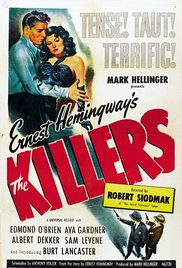

Killers, The (1946)
Crime|Film-Noir


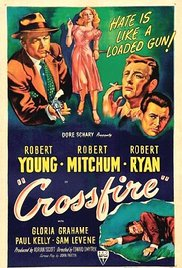

Crossfire (1947)
Crime|Film-Noir


In [26]:
displayMovies(recItemRatings.sort_values(by='prediction', ascending=False).head(30).index)

Compute MAE and RMSE for the test user.

In [27]:
userTestRatings = pd.DataFrame(data=test[test['userId'] == userId])
temp = userTestRatings.join(recItemRatings.loc[userTestRatings['movieId']], on='movieId')
mae = (temp['rating'] - temp['prediction']).abs().mean()
rmse = math.sqrt((temp['rating'] - temp['prediction']).pow(2).mean())
print(" MAE:", mae)
print("RMSE:", rmse)

 MAE: 0.865285261213
RMSE: 0.9781331224166757
